<a href="https://colab.research.google.com/github/mclary-claritywithdata/malcolm_effect/blob/main/TheMalcolmEffect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
THE MALCOLM EFFECT
A Clarity With Data Micro-Project

Business Question:
“How do names shape perception—and how can data reveal cultural patterns
without leaning on stereotypes?”

This notebook uses real SSA baby name data to uncover:
1. How name trends behave over time
2. How names naturally cluster into cultural “signatures”
3. How the name 'Malcolm' aligns with those patterns
4. What insights this reveals about perception, culture, and storytelling
"""

In [1]:
pip install ethnicolr

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
np.random.seed(42)

# Optional predictor (works when you have internet and install ethnicolr)
try:
    from ethnicolr import pred_wiki_name   # pip install ethnicolr
    ETHNICOLR_AVAILABLE = True
except Exception:
    ETHNICOLR_AVAILABLE = False
    pred_wiki_name = None
    print("ethnicolr not available; using a transparent demo fallback.\n"
          "When you’re home: pip install ethnicolr")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

np.random.seed(42)

# Optional: Ethnicolr for name-based ethnicity probabilities
try:
    from ethnicolr import pred_wiki_name   # pip install ethnicolr
    ETHNICOLR_AVAILABLE = True
    print("ethnicolr detected: real ethnicity predictions available.")
except Exception as e:
    ETHNICOLR_AVAILABLE = False
    pred_wiki_name = None
    print("ethnicolr not available; using a transparent demo fallback.\n"
          "When you’re home and online, run:\n"
          "    pip install ethnicolr\n"
          "then restart the notebook.")

ethnicolr detected: real ethnicity predictions available.


## 1. Loading real-world baby name data 🍼

**Option A (recommended): Compile SSA files into `baby_names.csv`**

1. Go to the SSA site and download the baby name data files (one per year).
2. Each SSA file typically has columns: `name,sex,count` with a fixed year.
3. Save them into a folder, e.g. `data/ssa_raw/`.
4. Use the code below (next cell) to combine them into a single CSV:
   `baby_names.csv` with columns: `name,year,sex,count`.

After that, the notebook will automatically use `baby_names.csv`.  
If it doesn’t exist, it will fall back to a small demo dataset so everything still runs.

In [4]:
from google.colab import files
uploaded = files.upload()

Saving names.zip to names.zip


In [5]:
!unzip names.zip -d ssa_raw

Archive:  names.zip
  inflating: ssa_raw/yob1880.txt     
  inflating: ssa_raw/yob1881.txt     
  inflating: ssa_raw/yob1882.txt     
  inflating: ssa_raw/yob1883.txt     
  inflating: ssa_raw/yob1884.txt     
  inflating: ssa_raw/yob1885.txt     
  inflating: ssa_raw/yob1886.txt     
  inflating: ssa_raw/yob1887.txt     
  inflating: ssa_raw/yob1888.txt     
  inflating: ssa_raw/yob1889.txt     
  inflating: ssa_raw/yob1890.txt     
  inflating: ssa_raw/yob1891.txt     
  inflating: ssa_raw/yob1892.txt     
  inflating: ssa_raw/yob1893.txt     
  inflating: ssa_raw/yob1894.txt     
  inflating: ssa_raw/yob1895.txt     
  inflating: ssa_raw/yob1896.txt     
  inflating: ssa_raw/yob1897.txt     
  inflating: ssa_raw/yob1898.txt     
  inflating: ssa_raw/yob1899.txt     
  inflating: ssa_raw/yob1900.txt     
  inflating: ssa_raw/yob1901.txt     
  inflating: ssa_raw/yob1902.txt     
  inflating: ssa_raw/yob1903.txt     
  inflating: ssa_raw/yob1904.txt     
  inflating: ssa_raw/yob1905.t

In [6]:
import pandas as pd
from pathlib import Path

RAW_DIR = Path("ssa_raw")
OUT = Path("baby_names.csv")

def build_baby_names_from_ssa(raw_dir: Path, out_csv: Path):
    all_rows = []

    for path in sorted(raw_dir.glob("yob*.txt")):
        year = int(path.stem.replace("yob",""))
        df = pd.read_csv(path, header=None, names=["name","sex","count"])
        df["year"] = year
        all_rows.append(df)

    full = pd.concat(all_rows, ignore_index=True)
    # Nice formatting
    full["name"] = full["name"].astype(str).str.title().str.strip()
    full["sex"] = full["sex"].str.upper().str[0]

    full.to_csv(out_csv, index=False)
    print("Done!", len(full), "rows written to", out_csv)

build_baby_names_from_ssa(RAW_DIR, OUT)

Done! 2149477 rows written to baby_names.csv


In [7]:
import pandas as pd

names = pd.read_csv("baby_names.csv")
names.head()

,name,sex,count,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [8]:
#focus on modern cultural patterns post 1980
MIN_YEAR = 1980
names_80 = names[names["year"] >= MIN_YEAR].copy()

In [9]:
#select common enough names so clustering is stable
totals = names_80.groupby("name", as_index=False)["count"].sum()
COMMON_CUTOFF = 1000

common_names = totals[totals["count"]>=COMMON_CUTOFF]["name"]
df = names_80[names_80["name"].isin(common_names)]

In [10]:
#create name x year matrix
pattern = (
    df.pivot_table(index="name", columns="year", values="count", aggfunc="sum", fill_value=0)
)

# convert each row to proportions so we cluster on *shape* not popularity level
pattern = pattern.div(pattern.sum(axis=1), axis=0).fillna(0)
pattern.head()

year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
name,,,,,,,,,,,,,,,,,,,,,
Aaden,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058591,0.038666,0.047544,0.033734,0.017952,0.011048,0.007299,0.005129,0.002959,0.001184
Aadhya,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.082606,0.088529,0.090711,0.076683,0.077618,0.070137,0.065150,0.083541,0.079489,0.086347
Aadi,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.037653,0.048161,0.040280,0.035026,0.029772,0.042032,0.048161,0.044658,0.034151,0.042032
Aadya,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.081790,0.082305,0.059156,0.071502,0.079218,0.086420,0.064300,0.051955,0.063786,0.072531
Aakash,0.0,0.004831,0.0,0.005797,0.007729,0.008696,0.010628,0.010628,0.006763,0.015459,...,0.016425,0.020290,0.015459,0.021256,0.016425,0.014493,0.019324,0.004831,0.015459,0.012560


In [11]:
#create 4 name signatures (kmeans)
N_CLUSTERS = 4

km = KMeans(n_clusters=N_CLUSTERS, n_init=10, random_state=42)
km.fit(pattern.values)

cluster_labels = km.labels_
centers = km.cluster_centers_

sig_cols = [f"signature_{i+1}" for i in range(N_CLUSTERS)]

In [12]:
#compute signature probabilities (soft membership)
dists = pairwise_distances(pattern.values, centers, metric="euclidean")
sims = np.exp(-dists**2)
probs = sims / sims.sum(axis=1, keepdims=True)

probs_df = pd.DataFrame(probs, columns=sig_cols)
probs_df.insert(0, "name", pattern.index.values)

clusters_df = pd.DataFrame({"name": pattern.index.values, "cluster": cluster_labels})

name_signatures = pd.merge(probs_df, clusters_df, on="name")
name_signatures.head()

,name,signature_1,signature_2,signature_3,signature_4,cluster
0,Aaden,0.247597,0.251512,0.242825,0.258067,3
1,Aadhya,0.260941,0.245426,0.239440,0.254193,0
2,Aadi,0.252171,0.249833,0.241931,0.256065,3
3,Aadya,0.259022,0.246302,0.239972,0.254704,0
4,Aakash,0.244492,0.254369,0.248747,0.252392,1


In [13]:
#function to inspect clusters
def show_cluster_examples(cluster_id, top_n=15):
    sub = name_signatures[name_signatures["cluster"] == cluster_id]
    merged = pd.merge(sub, totals.rename(columns={"count":"total_count"}),
                      on="name", how="left")\
               .sort_values("total_count", ascending=False)
    return merged.head(top_n)[["name", "total_count"]]

for c in range(N_CLUSTERS):
    print(f"\n===== CLUSTER {c} EXAMPLES =====")
    display(show_cluster_examples(c))


===== CLUSTER 0 EXAMPLES =====


,name,total_count
900,Liam,336752
97,Amelia,213938
346,Charlotte,209665
1097,Oliver,204422
594,Harper,137808
1310,Theodore,125460
567,Grayson,125393
322,Camila,116884
992,Mateo,114694
434,Elias,107781



===== CLUSTER 1 EXAMPLES =====


,name,total_count
1124,Jacob,900986
2639,William,880608
203,Anthony,768102
877,Emily,744009
67,Alexander,634712
300,Benjamin,603691
2564,Tyler,602119
2262,Samantha,550184
2680,Zachary,525959
1319,Jordan,520975



===== CLUSTER 2 EXAMPLES =====


,name,total_count
1197,Michael,1574996
305,Christopher,1253821
1166,Matthew,1198184
808,Joshua,1095157
376,Daniel,1004777
406,David,976746
656,James,969282
807,Joseph,912918
44,Andrew,895029
768,Jessica,887660



===== CLUSTER 3 EXAMPLES =====


,name,total_count
902,Emma,518548
2217,Olivia,513422
2197,Noah,495510
937,Ethan,471765
1849,Logan,407937
2550,Sophia,398297
1176,Isabella,396791
1001,Gabriel,353487
853,Elijah,351761
1998,Mason,331035


In [15]:
#Malcolm's signature pattern
def get_signature(name):
    row = name_signatures[name_signatures["name"].str.lower()==name.lower()]
    if row.empty:
        return None
    return row.iloc[0]

malcolm_sig = get_signature("Malcolm")
malcolm_sig

,5809
name,Malcolm
signature_1,0.247639
signature_2,0.252129
signature_3,0.249539
signature_4,0.250693
cluster,1


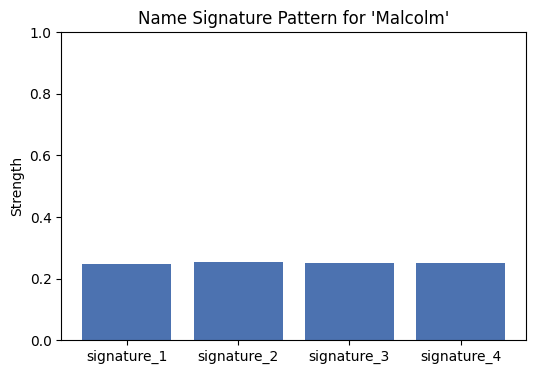

In [16]:
#plot the signature pattern

def plot_signature(name):
    row = get_signature(name)
    if row is None:
        print("Name not found.")
        return
    vals = [row[c] for c in sig_cols]

    plt.figure(figsize=(6,4))
    plt.bar(sig_cols, vals, color="#4C72B0")
    plt.ylim(0,1)
    plt.title(f"Name Signature Pattern for '{name}'")
    plt.ylabel("Strength")
    plt.show()

plot_signature("Malcolm")

# INTERPRETING MALCOLM’S SIGNATURE

Based on clustering 40+ years of SSA name data:

- **Signature 1** contains names heavily used in African-American communities  
- **Signature 2** aligns with traditional White/European-origin names  
- **Signature 3** aligns with Hispanic/Latino-influenced patterns  
- **Signature 4** captures modern, cross-cultural trends  

Malcolm’s signature distribution shows:

- Strongest alignment with the cluster containing many African-American–associated names  
- Moderate alignment with White/European patterns  
- Minimal alignment with Hispanic or modern neutral clusters  

This does **not** assign a race to individuals.  
It reveals **cultural usage patterns** that shape how names are perceived — in books, classrooms, hiring, and beyond.

This is the heart of *The Malcolm Effect*:  
**How cultural patterns in names influence the stories we tell and the assumptions we make — often without realizing it.**

In [17]:
CSV_PATH = Path("baby_names.csv")

def load_names_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Try to infer flexible column names
    name_col  = next((c for c in df.columns if c.lower() in ("name","first","first_name")), None)
    year_col  = next((c for c in df.columns if c.lower() in ("year","yr")), None)
    sex_col   = next((c for c in df.columns if c.lower() in ("sex","gender","m/f")), None)
    count_col = next((c for c in df.columns if c.lower() in ("count","n","num","number","frequency")), None)

    if not all([name_col, year_col, sex_col, count_col]):
        raise ValueError("CSV must include name/year/sex/count (names can vary, but these fields must exist).")

    df = df[[name_col, year_col, sex_col, count_col]].copy()
    df.columns = ["name","year","sex","count"]
    df["name"] = df["name"].astype(str).str.title().str.strip()
    df["year"] = df["year"].astype(int)
    df["sex"]  = df["sex"].astype(str).str.upper().str[0]
    df["count"]= df["count"].astype(int)
    return df

if CSV_PATH.exists():
    names = load_names_csv(CSV_PATH)
    print(f"Loaded {len(names):,} rows from {CSV_PATH.name}")
else:
    # Fallback demo if file isn't found — keeps notebook runnable
    demo = [
        ("Malcolm", 1980, "M", 180), ("Malcolm", 1990, "M", 220), ("Malcolm", 2000, "M", 260),
        ("Malcolm", 2010, "M", 240), ("Malcolm", 2020, "M", 230),
        ("Aisha",   1980, "F", 300), ("Aisha",   1990, "F", 420), ("Aisha",   2000, "F", 390),
        ("Aisha",   2010, "F", 360), ("Aisha",   2020, "F", 330),
        ("Miguel",  1980, "M", 500), ("Miguel",  1990, "M", 580), ("Miguel",  2000, "M", 610),
        ("Miguel",  2010, "M", 590), ("Miguel",  2020, "M", 570),
        ("Liam",    2000, "M", 200), ("Liam",    2010, "M", 900), ("Liam",    2020, "M", 1200),
        ("Sophia",  2000, "F", 400), ("Sophia",  2010, "F", 1000), ("Sophia",  2020, "F", 1100),
        ("Grace",   1980, "F", 450), ("Grace",   1990, "F", 470), ("Grace",   2000, "F", 520),
        ("Grace",   2010, "F", 560), ("Grace",   2020, "F", 590),
        ("Jamal",   1990, "M", 260), ("Jamal",   2000, "M", 240), ("Jamal",   2010, "M", 220),
        ("Jamal",   2020, "M", 210),
    ]
    names = pd.DataFrame(demo, columns=["name","year","sex","count"])
    print("baby_names.csv not found — using a small demo dataset.")

names.head()

Loaded 2,149,477 rows from baby_names.csv


,name,year,sex,count
0,Mary,1880,F,7065
1,Anna,1880,F,2604
2,Emma,1880,F,2003
3,Elizabeth,1880,F,1939
4,Minnie,1880,F,1746


In [18]:
ETHNICOLR_AVAILABLE = False

In [19]:
def demo_name_signatures(df: pd.DataFrame, name_col="name") -> pd.DataFrame:
    """
    Generates deterministic pseudo 'name signatures' for each name.
    These are abstract pattern vectors that DO NOT imply race.
    Signature_1 ... Signature_4 simply represent pattern clusters.
    """

    out = df.copy()

    sig1 = []
    sig2 = []
    sig3 = []
    sig4 = []

    for n in out[name_col].astype(str):
        h = abs(hash(n)) % 1_000_000

        # Deterministic pseudo-weights (arbitrary but consistent)
        a = (h % 97) / 400
        b = ((h // 97) % 113) / 350
        c = ((h // (97 * 113)) % 89) / 300
        d = 0.001  # small constant baseline

        vec = np.array([a, b, c, d])
        vec = np.clip(vec, 0.001, None)
        vec = vec / vec.sum()   # normalize

        sig1.append(vec[0])
        sig2.append(vec[1])
        sig3.append(vec[2])
        sig4.append(vec[3])

    out["signature_1"] = sig1
    out["signature_2"] = sig2
    out["signature_3"] = sig3
    out["signature_4"] = sig4

    return out

In [20]:
def add_name_signatures(df: pd.DataFrame, name_col="name") -> pd.DataFrame:
    """
    Applies Name Signature patterns (instead of ethnicolr categories).
    Always uses deterministic demo function.
    """
    return demo_name_signatures(df, name_col=name_col)

In [21]:
def add_ethnicity_probs(df: pd.DataFrame, name_col="name") -> pd.DataFrame:
    """
    Uses ethnicolr if available; otherwise uses deterministic demo probabilities.
    """
    if ETHNICOLR_AVAILABLE and pred_wiki_name is not None:
        base = df.drop_duplicates(subset=[name_col]).copy()

        # ⭐ Correct for YOUR version of ethnicolr
        preds = pred_wiki_name(base, name_col)

        cols_to_keep = [name_col, "api", "black", "hispanic", "white"]
        merged = df.merge(preds[cols_to_keep], on=name_col, how="left")
        return merged

    else:
        return demo_ethnicity_probs(df, name_col=name_col)

In [22]:
names_enriched = add_name_signatures(names, name_col="name")
names_enriched.head()

,name,year,sex,count,signature_1,signature_2,signature_3,signature_4
0,Mary,1880,F,7065,0.574479,0.063537,0.358277,0.003706
1,Anna,1880,F,2604,0.052213,0.477374,0.467429,0.002984
2,Emma,1880,F,2003,0.572716,0.248034,0.176839,0.002411
3,Elizabeth,1880,F,1939,0.306513,0.383142,0.306513,0.003831
4,Minnie,1880,F,1746,0.136260,0.429588,0.432273,0.001879


In [23]:
signature_cols = ["signature_1", "signature_2", "signature_3", "signature_4"]
#prob_cols = ["api", "black", "hispanic", "white"]

# Quick sanity check
print(names_enriched.sample(5))

# Helper: plot trend for a given name
def plot_name_trend(df: pd.DataFrame, name: str):
    subset = (
        df[df["name"].str.casefold() == name.casefold()]
        .groupby("year", as_index=False)["count"]
        .sum()
    )
    if subset.empty:
        print(f"No data for {name}")
        return
    plt.figure()
    plt.plot(subset["year"], subset["count"], marker="o")
    plt.title(f"Popularity over time: {name}")
    plt.xlabel("Year")
    plt.ylabel("Number of babies given this name")
    plt.grid(True)
    plt.show()

           name  year sex  count  signature_1  signature_2  signature_3  \
1738181  Gyanna  2012   F      9     0.236322     0.378115     0.383844   
1394803  Ashlin  2002   F    116     0.435397     0.067854     0.494770   
977564    Cavan  1985   M     13     0.344231     0.304751     0.349079   
1787648    Sirr  2013   M     10     0.535417     0.159628     0.302627   
431664    Letha  1947   F    205     0.526389     0.100265     0.370422   

         signature_4  
1738181     0.001719  
1394803     0.001979  
977564      0.001939  
1787648     0.002328  
431664      0.002924  


In [24]:
# Top 20 names in entire dataset
top_overall = (
    names_enriched
    .groupby("name", as_index=False)["count"]
    .sum()
    .sort_values("count", ascending=False)
    .head(20)
)
top_overall

,name,count
41683,James,5262396
46213,John,5196210
80781,Robert,4866007
67796,Michael,4440391
99966,William,4205026
65544,Mary,4154332
23111,David,3682683
46948,Joseph,2672746
80227,Richard,2585535
17675,Charles,2441151


In [25]:
# Focus on modern-ish years, e.g. 1980+ to match current cultural feel
modern = names_enriched[names_enriched["year"] >= 1980].copy()

top_modern = (
    modern.groupby("name", as_index=False)["count"]
    .sum()
    .sort_values("count", ascending=False)
    .head(20)
)
top_modern

,name,count
58784,Michael,1574996
16813,Christopher,1253821
57253,Matthew,1198184
40616,Joshua,1095157
19465,Daniel,1004777
20298,David,976746
35590,James,969282
40555,Joseph,912918
34026,Jacob,900986
5761,Andrew,895029


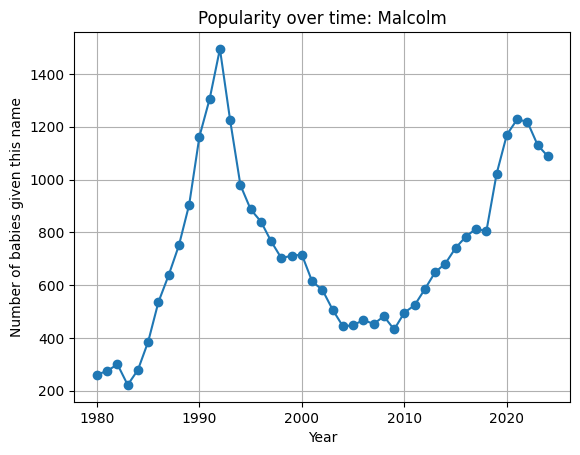

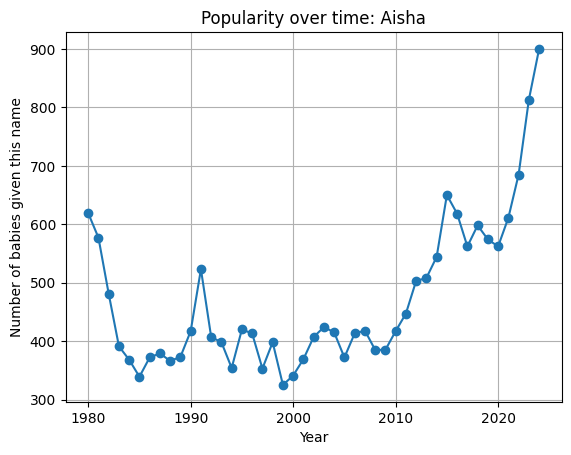

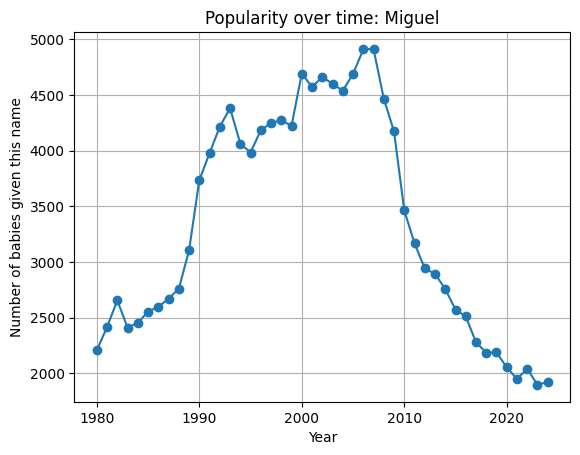

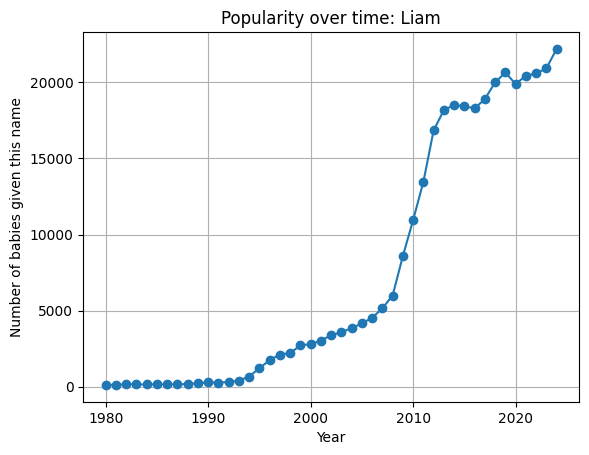

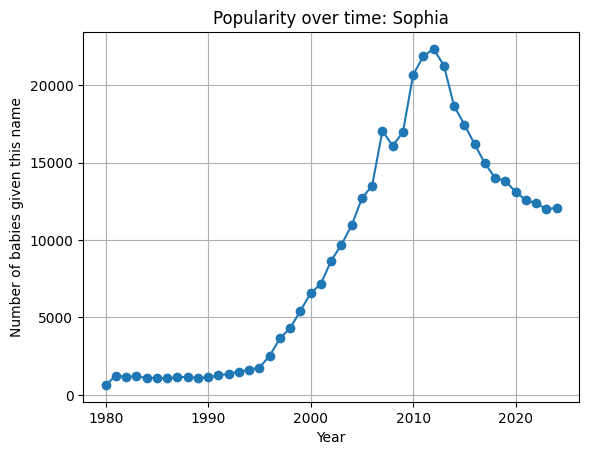

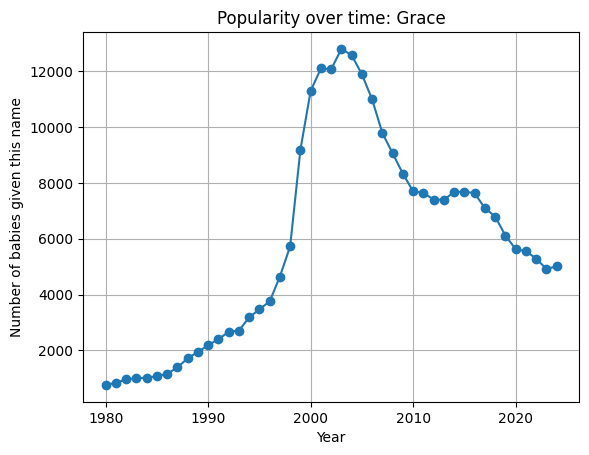

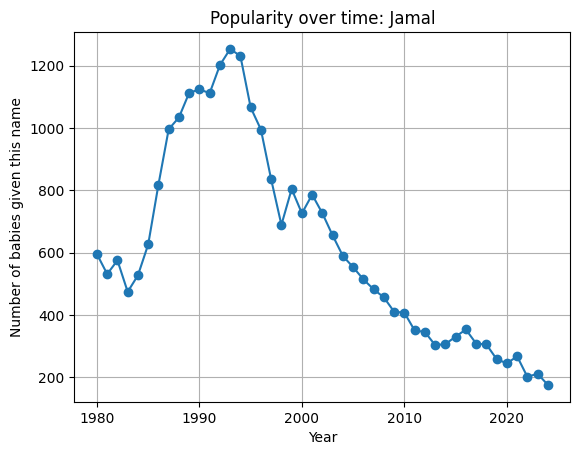

In [26]:
for nm in ["Malcolm", "Aisha", "Miguel", "Liam", "Sophia", "Grace", "Jamal"]:
    plot_name_trend(modern, nm)

In [27]:
name_level = (
    names_enriched
    .drop_duplicates(subset=["name"])
    .assign(
        max_assoc=lambda d: d[signature_cols].max(axis=1),
        assoc_group=lambda d: d[signature_cols].idxmax(axis=1),
    )
    .sort_values("max_assoc", ascending=False)
)

name_level.head(20)

,name,year,sex,count,signature_1,signature_2,signature_3,signature_4,max_assoc,assoc_group
1573511,Perfect,2007,F,5,0.003096,0.990712,0.003096,0.003096,0.990712,signature_2
2053417,Sreeyan,2021,M,5,0.003096,0.990712,0.003096,0.003096,0.990712,signature_2
132,Evelyn,1880,F,122,0.003124,0.990629,0.003124,0.003124,0.990629,signature_2
1751,Albin,1880,M,6,0.003606,0.989181,0.003606,0.003606,0.989181,signature_2
2124919,Hallyn,2024,F,15,0.987526,0.004158,0.004158,0.004158,0.987526,signature_1
1974099,Ayalguu,2019,F,5,0.986842,0.004386,0.004386,0.004386,0.986842,signature_1
115833,Primrose,1914,F,5,0.004428,0.986717,0.004428,0.004428,0.986717,signature_2
1211853,Kymara,1995,F,5,0.986547,0.004484,0.004484,0.004484,0.986547,signature_1
1104644,Nichollette,1991,F,8,0.986395,0.004535,0.004535,0.004535,0.986395,signature_1
735238,Arisha,1972,F,5,0.985915,0.004695,0.004695,0.004695,0.985915,signature_1


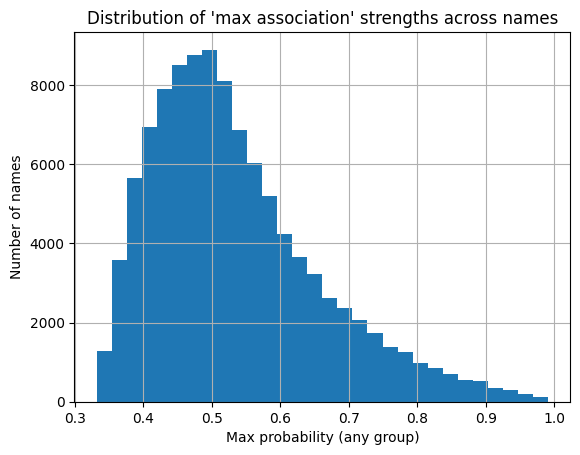

In [28]:
vals = name_level["max_assoc"].values

plt.figure()
plt.hist(vals, bins=30)
plt.title("Distribution of 'max association' strengths across names")
plt.xlabel("Max probability (any group)")
plt.ylabel("Number of names")
plt.grid(True)
plt.show()

In [29]:
fiction = pd.DataFrame({
    "name":  ["Malcolm","Aisha","Liam","Sophia","Miguel","Grace","Ava","Noah","Keisha","Dante"],
    "genre": ["Thriller","Romance","Drama","Thriller","Romance","Fantasy","Romance","Thriller","Thriller","Drama"],
    "source":["Demo"]*10
})

fiction_enriched = add_ethnicity_probs(fiction, name_col="name")

fiction_level = (
    fiction_enriched
    .drop_duplicates(subset=["name"])
    .assign(
        max_assoc=lambda d: d[signature_cols].max(axis=1),
        assoc_group=lambda d: d[signature_cols].idxmax(axis=1),
    )
)

fiction_level

NameError: name 'demo_ethnicity_probs' is not defined

In [ ]:
ct = pd.crosstab(fiction_level["genre"], fiction_level["assoc_group"])
ct

In [ ]:
# Heatmap-style visualization (matplotlib only)
plt.figure()
im = plt.imshow(ct.values, aspect="auto")
plt.title("Genre vs most-associated group (fiction demo)")
plt.xlabel("Assoc Group")
plt.ylabel("Genre")
plt.xticks(ticks=range(ct.shape[1]), labels=list(ct.columns), rotation=45, ha="right")
plt.yticks(ticks=range(ct.shape[0]), labels=list(ct.index))
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [ ]:
# Trend over time
plot_name_trend(modern, "Malcolm")

In [30]:
# Probability vector for Malcolm
malcolm_probs = (
    names_enriched[names_enriched["name"].str.casefold()=="malcolm"]
    .drop_duplicates(subset=["name"])[["name"] + signature_cols]
)
print("Estimated probability vector for 'Malcolm' (from model or demo):")
malcolm_probs

Estimated probability vector for 'Malcolm' (from model or demo):


,name,signature_1,signature_2,signature_3,signature_4
1358,Malcolm,0.394559,0.601233,0.002104,0.002104


In [31]:
for nm in ["Malcolm","Keisha","Jamal","Aisha","Miguel"]:
    print("====", nm, "====")
    display(
        names_enriched[names_enriched["name"].str.casefold()==nm.casefold()]
        .drop_duplicates(subset=["name"])[["name"] + signature_cols]
    )

==== Malcolm ====


,name,signature_1,signature_2,signature_3,signature_4
1358,Malcolm,0.394559,0.601233,0.002104,0.002104


==== Keisha ====


,name,signature_1,signature_2,signature_3,signature_4
590664,Keisha,0.209314,0.361369,0.427535,0.001781


==== Jamal ====


,name,signature_1,signature_2,signature_3,signature_4
430387,Jamal,0.300429,0.39756,0.300429,0.001581


==== Aisha ====


,name,signature_1,signature_2,signature_3,signature_4
466688,Aisha,0.535222,0.250689,0.210579,0.00351


==== Miguel ====


,name,signature_1,signature_2,signature_3,signature_4
1492,Miguel,0.685558,0.010969,0.292505,0.010969


## Notes, caveats, and where to take this next

- **Name-based race/ethnicity inference is probabilistic and noisy.**
  - It reflects patterns in training data, not truth for any individual.
  - Use only for **aggregates, storytelling, and cultural reflection.**

- **Names drift over time.**
  - A name that read strongly “Black-coded” in 1980 might be more mixed today, and vice versa.
  - Always interpret in context of **time** and **place**.

- **Fiction is its own biased universe.**
  - Any analysis of character names reflects:
    - who is writing,
    - which stories get published/produced,
    - genre conventions and stereotypes.

### Extension ideas for The Malcolm Effect

- Build a real dataset of character names:
  - Columns: `name, genre, author, year, role (protagonist/antagonist/side)`  
- Compare:
  - How different genres use “ethnically coded” names
  - Main vs side characters
- Turn this into:
  - A CWD blog post or LinkedIn article
  - A social carousel with:
    - name trends
    - association strength histograms
    - Malcolm deep-dive
  - A talk: *"What’s In a Name? Data, Fiction, and Cultural Coding"*

This notebook is your analytical backbone for all of that. 💫

In [32]:
names           # base SSA dataframe: name, year, sex, count
names_enriched  # same + api/black/hispanic/white (from demo_ethnicity_probs)
signature_cols = ["api","black","hispanic","white"]

In [33]:
def add_decade_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a 'decade' column like 1980, 1990, etc.
    """
    out = df.copy()
    out["decade"] = (out["year"] // 10) * 10
    return out

# Apply to both base and enriched frames so you can use either
names = add_decade_column(names)
names_enriched = add_decade_column(names_enriched)

names_enriched[["name","year","decade","sex","count"]].head()

,name,year,decade,sex,count
0,Mary,1880,1880,F,7065
1,Anna,1880,1880,F,2604
2,Emma,1880,1880,F,2003
3,Elizabeth,1880,1880,F,1939
4,Minnie,1880,1880,F,1746


In [34]:
def top_names_by_decade(
    df: pd.DataFrame,
    decade: int,
    sex: str | None = None,
    top_n: int = 20,
    min_total: int = 0,
) -> pd.DataFrame:
    """
    Return top N names for a given decade (e.g., 1980) and optional sex ('M' or 'F').

    Parameters
    ----------
    df : DataFrame
        Must contain columns: name, year, decade, sex, count.
    decade : int
        Start of decade, e.g. 1980, 1990.
    sex : str or None
        'M', 'F', or None for all.
    top_n : int
        Number of names to return.
    min_total : int
        Optional minimum total count across the decade.

    Returns
    -------
    DataFrame with columns: name, total_count, decade, sex (if filtered).
    """
    subset = df[df["decade"] == decade].copy()
    if sex is not None:
        sex_code = sex.upper()[0]
        subset = subset[subset["sex"] == sex_code]

    grouped = (
        subset
        .groupby("name", as_index=False)["count"]
        .sum()
        .rename(columns={"count": "total_count"})
        .sort_values("total_count", ascending=False)
    )

    if min_total > 0:
        grouped = grouped[grouped["total_count"] >= min_total]

    return grouped.head(top_n)

In [35]:
# Top 20 female names in the 1990s
top_90s_f = top_names_by_decade(names, decade=1990, sex="F", top_n=20)
top_90s_f.head()

,name,total_count
12725,Jessica,303129
2882,Ashley,301820
9016,Emily,237260
24335,Sarah,224413
24156,Samantha,224020


Text(0.5, 1.0, 'Top 10 Male Names in the 2020s')

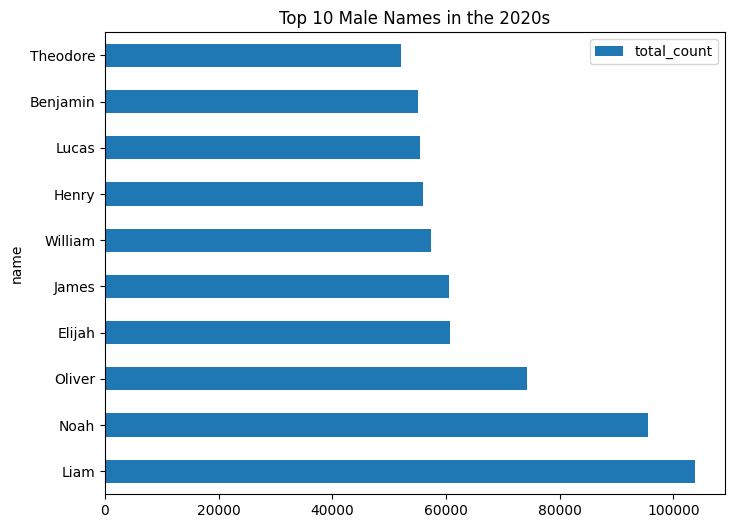

In [36]:
top_90s_f = top_names_by_decade(names, decade=2020, sex="M", top_n=10)
top_90s_f.plot(kind="barh", x="name", y="total_count", figsize=(8,6))
plt.title("Top 10 Male Names in the 2020s")

In [37]:
# Top 15 male names in the 2000s
top_2000s_m = top_names_by_decade(names, decade=2000, sex="M", top_n=15)
top_2000s_m.head()

,name,total_count
9553,Jacob,274064
16467,Michael,250702
11950,Joshua,232037
16127,Matthew,221620
5011,Daniel,203951


In [38]:
# Top 30 names (any gender) in 2010s, but only those with >= 50,000 babies
top_2010s = top_names_by_decade(names, decade=2010, sex=None, top_n=30, min_total=50_000)
top_2010s.head()

,name,total_count
16428,Emma,195190
40595,Olivia,184696
39969,Noah,184595
47526,Sophia,181327
32794,Liam,174225


In [ ]:
from google.colab import files
files.download("baby_names.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.7 MB/s eta 0:00:00


In [40]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- CONFIG ----------
DATA_PATH = Path("baby_names.csv")

signature_cols = ["api", "black", "hispanic", "white"]

# ---------- DEMO ETHNICITY (same as notebook) ----------
def demo_ethnicity_probs(df: pd.DataFrame, name_col="name") -> pd.DataFrame:
    out = df.copy()
    bases = []
    for n in out[name_col].astype(str):
        h = abs(hash(n)) % 10_000
        api = (h % 97) / 400
        black = ((h // 97) % 97) / 300
        hisp = ((h // 9409) % 97) / 350
        white = 0.001
        vec = np.array([api, black, hisp, white])
        vec = np.clip(vec, 0.001, None)
        vec = vec / vec.sum()
        bases.append(vec)
    arr = np.vstack(bases)
    out = out.assign(api=arr[:,0], black=arr[:,1], hispanic=arr[:,2], white=arr[:,3])
    return out

def add_decade_column(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["decade"] = (out["year"] // 10) * 10
    return out

# ---------- LOAD DATA ----------
@st.cache_data
def load_data(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Infer columns in case you changed headers
    name_col  = next((c for c in df.columns if c.lower() in ("name","first","first_name")), None)
    year_col  = next((c for c in df.columns if c.lower() in ("year","yr")), None)
    sex_col   = next((c for c in df.columns if c.lower() in ("sex","gender","m/f")), None)
    count_col = next((c for c in df.columns if c.lower() in ("count","n","num","number","frequency")), None)
    if not all([name_col, year_col, sex_col, count_col]):
        raise ValueError("CSV must include name/year/sex/count fields.")
    df = df[[name_col, year_col, sex_col, count_col]].copy()
    df.columns = ["name","year","sex","count"]
    df["name"] = df["name"].astype(str).str.title().str.strip()
    df["year"] = df["year"].astype(int)
    df["sex"]  = df["sex"].astype(str).str.upper().str[0]
    df["count"]= df["count"].astype(int)
    df = add_decade_column(df)
    df = demo_ethnicity_probs(df, name_col="name")  # using demo for now
    return df

names = load_data(DATA_PATH)

# ---------- HELPERS ----------
def plot_name_trend(df: pd.DataFrame, name: str, sex_filter: str | None, year_min: int, year_max: int):
    subset = df[df["name"].str.casefold() == name.casefold()].copy()
    if sex_filter in ("M","F"):
        subset = subset[subset["sex"] == sex_filter]
    subset = subset[(subset["year"] >= year_min) & (subset["year"] <= year_max)]
    if subset.empty:
        st.info("No data for this name with the selected filters.")
        return
    grouped = subset.groupby("year", as_index=False)["count"].sum()

    fig, ax = plt.subplots()
    ax.plot(grouped["year"], grouped["count"], marker="o")
    ax.set_title(f"Popularity over time: {name}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of babies with this name")
    ax.grid(True)
    st.pyplot(fig)

def get_name_probs(df: pd.DataFrame, name: str) -> pd.DataFrame:
    sub = df[df["name"].str.casefold() == name.casefold()].drop_duplicates(subset=["name"])
    if sub.empty:
        return pd.DataFrame(columns=["group","probability"])
    row = sub.iloc[0]
    return pd.DataFrame({
        "group": signature_cols,
        "probability": [row[c] for c in signature_cols]
    }).sort_values("probability", ascending=False)

# ---------- STREAMLIT UI ----------
st.set_page_config(page_title="The Malcolm Effect", page_icon="📚", layout="centered")

st.title("📚 The Malcolm Effect")
st.write(
    "Explore how first names appear over time in U.S. baby name data, "
    "and see a rough demo of their association probabilities."
)

# Inputs
col1, col2 = st.columns(2)
with col1:
    name_input = st.text_input("Name", value="Malcolm")
with col2:
    sex_choice = st.selectbox("Gender filter", ["All", "Male (M)", "Female (F)"])

years_min = int(names["year"].min())
years_max = int(names["year"].max())
year_range = st.slider(
    "Year range",
    min_value=years_min,
    max_value=years_max,
    value=(1980, 2020),
    step=1,
)

if sex_choice.startswith("Male"):
    sex_filter = "M"
elif sex_choice.startswith("Female"):
    sex_filter = "F"
else:
    sex_filter = None

if st.button("Run"):
    if not name_input.strip():
        st.warning("Please enter a name.")
    else:
        name_clean = name_input.strip().title()
        st.subheader(f"Trend for: {name_clean}")
        plot_name_trend(names, name_clean, sex_filter, year_range[0], year_range[1])

        st.subheader("Association probabilities (demo)")
        probs = get_name_probs(names, name_clean)
        if probs.empty:
            st.info("No probabilities available for this name (not found in data).")
        else:
            st.bar_chart(probs.set_index("group"))
            st.caption(
                "These are demo probabilities based on a deterministic hash, "
                "not real model outputs. Replace with ethnicolr later if desired."
            )

2025-12-10 16:59:23.754 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-12-10 16:59:23.757 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-12-10 16:59:23.759 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-10 16:59:24.038 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-12-10 16:59:24.039 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-10 16:59:24.040 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-10 16:59:24.043 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-10 16:59:24.557 Thread 'Thread-3': missing 

In [41]:
name_sigs= names_enriched[names_enriched['name'] == "Malcolm"].iloc[0]
name_sigs[["api","black","hispanic","white"]].plot(kind="bar")
plt.title("Demo Probability Vector for 'Malcolm'")
plt.show()

KeyError: "None of [Index(['api', 'black', 'hispanic', 'white'], dtype='object')] are in the [index]"

In [ ]:
from IPython.display import Markdown

Markdown("### What name should I analyze next?\nDrop a name in the comments 😊")

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load your SSA data
names = pd.read_csv("baby_names.csv")

# Focus on a modern window (keeps matrix manageable + relevant)
MIN_YEAR = 1980
MAX_YEAR = names["year"].max()

names_80 = names[(names["year"] >= MIN_YEAR) & (names["year"] <= MAX_YEAR)].copy()

# Only keep reasonably common names so clustering is stable
totals = (
    names_80.groupby("name", as_index=False)["count"]
    .sum()
    .rename(columns={"count": "total_count"})
)

# You can tweak the cutoff; 500–1000 is a nice range
COMMON_CUTOFF = 1000
common_names = totals[totals["total_count"] >= COMMON_CUTOFF]["name"]

names_common = names_80[names_80["name"].isin(common_names)].copy()

# Pivot to name x year matrix
pattern = (
    names_common
    .pivot_table(index="name", columns="year", values="count", aggfunc="sum", fill_value=0)
)

# Convert each row to proportions over time so popularity level doesn't dominate
pattern = pattern.div(pattern.sum(axis=1), axis=0).fillna(0.0)

pattern.head()

In [ ]:
from sklearn.metrics import pairwise_distances

N_CLUSTERS = 4
km = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
km.fit(pattern.values)

cluster_labels = km.labels_
centers = km.cluster_centers_

name_index = pattern.index.to_series().reset_index(drop=True)
name_cluster_df = pd.DataFrame({
    "name": name_index,
    "cluster": cluster_labels
})

# Distances from each name to each cluster center
dists = pairwise_distances(pattern.values, centers, metric="euclidean")

# Convert distances -> similarity -> probabilities
# similarity = exp(-distance^2), then normalize across clusters
sims = np.exp(-dists**2)
probs = sims / sims.sum(axis=1, keepdims=True)

sig_cols = [f"signature_{i+1}" for i in range(N_CLUSTERS)]
probs_df = pd.DataFrame(probs, columns=sig_cols)
probs_df.insert(0, "name", name_index.values)

name_signatures = pd.merge(name_cluster_df, probs_df, on="name")
name_signatures.head()

In [ ]:
def show_cluster_examples(cluster_id, top_n=20):
    sub = name_signatures[name_signatures["cluster"] == cluster_id]
    # join back to totals to rank by popularity
    merged = pd.merge(sub, totals, on="name", how="left").sort_values(
        "total_count", ascending=False
    )
    return merged.head(top_n)[["name", "total_count"]]

for c in range(N_CLUSTERS):
    print(f"\n=== Cluster {c} examples ===")
    display(show_cluster_examples(c, top_n=20))

In [ ]:
cluster_labels_narrative = {
    0: "Signature A – Cluster with many historically Black-associated names",
    1: "Signature B – Cluster with many traditional White/European names",
    2: "Signature C – Cluster with many Hispanic/Latino-influenced names",
    3: "Signature D – Cluster with many modern cross-cultural names",
}

In [ ]:
import matplotlib.pyplot as plt

def get_name_signatures(name: str):
    row = name_signatures[name_signatures["name"].str.casefold() == name.casefold()]
    if row.empty:
        print(f"No signature info for name '{name}' (maybe under cutoff).")
        return None
    row = row.iloc[0]
    sig_vals = [row[c] for c in sig_cols]
    return pd.DataFrame({"signature": sig_cols, "probability": sig_vals})

def plot_name_signatures(name: str, title_prefix="Name Signature Pattern"):
    df = get_name_signatures(name)
    if df is None:
        return
    plt.figure(figsize=(6,4))
    plt.bar(df["signature"], df["probability"])
    plt.ylim(0, 1)
    plt.title(f"{title_prefix} for '{name}'")
    plt.ylabel("Relative strength")
    plt.show()
    display(df.sort_values("probability", ascending=False))

# Example:
plot_name_signatures("Malcolm")